# loading dataset

In [1]:
import pandas as pd
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import time
import wave

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
path="/content/drive/MyDrive/ALL"

In [5]:
audio_files=[os.path.join(path, f) for f in os.listdir(path) if f.endswith('.wav')]

In [6]:
l1=[]
l2=[]
l3=[]
l4=[]
for i in range(len(audio_files)):
    file_name=audio_files[i].split("/")[-1].split("_")[-1]
    audio_path = audio_files[i]
    y, sr = librosa.load(audio_path)
    l3.append(y)
    l4.append(sr)
    if file_name[0]=="n":#neutral
        l1.append(audio_files[i].split("/")[-1])
        l2.append("neutral")
    elif file_name[0] == 'h':#happy
        l1.append(audio_files[i].split("/")[-1])
        l2.append("happy")
    elif file_name[0] == 'd':#disgust
        l1.append(audio_files[i].split("/")[-1])
        l2.append("disgust")
    elif file_name[0] == 'a':#angry
        l1.append(audio_files[i].split("/")[-1])
        l2.append("angry")
    elif file_name[0] == 'c':#calm
        l1.append(audio_files[i].split("/")[-1])
        l2.append("calm")
    elif file_name[0] == 'f':#fearful
        l1.append(audio_files[i].split("/")[-1])
        l2.append("fearful")
    elif file_name[0] == 's':
        if file_name[1] == 'a':#sad
            l1.append(audio_files[i].split("/")[-1])
            l2.append("sad")
        elif file_name[1] == 'u':#surprise
            l1.append(audio_files[i].split("/")[-1])
            l2.append("surprise")

In [7]:
# Create the list of emotions
list_emotions = list(zip(l1, l2))

# Create the audio array
audio_array = list(zip(l3, l2))

# Create the list of audio file paths
list_paths = list(zip(audio_files, l2))


In [8]:
df_path=pd.DataFrame(list_paths, columns=['File_Path', 'Emotion_label'])
df_path

,File_Path,Emotion_label
0,/content/drive/MyDrive/ALL/DC_a01.wav,angry
1,/content/drive/MyDrive/ALL/DC_a07.wav,angry
2,/content/drive/MyDrive/ALL/DC_a02.wav,angry
3,/content/drive/MyDrive/ALL/DC_a04.wav,angry
4,/content/drive/MyDrive/ALL/DC_a08.wav,angry
...,...,...
475,/content/drive/MyDrive/ALL/KL_n10.wav,neutral
476,/content/drive/MyDrive/ALL/KL_su12.wav,surprise
477,/content/drive/MyDrive/ALL/KL_n28.wav,neutral
478,/content/drive/MyDrive/ALL/KL_n13.wav,neutral


In [9]:
df_files=pd.DataFrame(list_emotions, columns=['File_Name', 'Emotion_label'])
df_files

,File_Name,Emotion_label
0,DC_a01.wav,angry
1,DC_a07.wav,angry
2,DC_a02.wav,angry
3,DC_a04.wav,angry
4,DC_a08.wav,angry
...,...,...
475,KL_n10.wav,neutral
476,KL_su12.wav,surprise
477,KL_n28.wav,neutral
478,KL_n13.wav,neutral


# Feature extraction

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data,rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

In [11]:
def extract_features(x, sr):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc))
    return result


In [12]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [13]:
x, y = [], []
for path, emotion in zip(df_path.File_Path, df_path.Emotion_label):

    feature = get_features(path)
    feature=np.reshape(feature,(60))
    #feature.ravel()
    x.append(feature)
    y.append(emotion)

In [14]:
Emotions = pd.DataFrame(x)
Emotions['labels'] = y
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,labels
0,-263.300262,141.653137,9.112868,34.927040,9.102954,-8.535455,-36.883102,-6.173548,-4.386553,-18.353758,...,-1.986035,-5.359133,-2.889169,4.794848,-6.665481,-3.414181,4.941877,-8.410620,-5.193048,angry
1,-265.110016,132.180878,-16.641783,14.746445,-2.008146,-11.634149,-23.319561,3.265514,-5.327899,-14.216903,...,-5.640541,-7.628936,3.298486,-2.451738,-0.820990,6.164408,-2.055632,-2.495074,0.049660,angry
2,-243.074387,156.171066,-24.651005,17.625463,12.309278,-6.909586,-31.995726,3.914088,4.306551,-18.732313,...,0.134043,-6.178525,3.908497,1.474156,-8.155973,-4.067616,-1.884045,-7.254447,-2.608000,angry
3,-261.693390,117.652107,2.632990,17.267838,7.916267,-3.461671,-32.682476,-7.869678,-1.252566,-14.944409,...,-3.852296,-5.495389,-1.316410,4.791965,-6.947454,-3.842241,4.275601,-9.129858,-5.603767,angry
4,-240.565033,103.684662,4.664193,27.215553,-10.401411,-7.675876,-30.947647,-7.637542,-2.659107,-11.900902,...,-8.227779,-7.235291,0.817297,10.283892,-2.672752,-1.007045,0.169804,-10.733924,-4.212610,angry


#splitting data

In [15]:
x = Emotions.iloc[: ,:-1].values
y = Emotions['labels'].values

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [17]:
#from sklearn.preprocessing import OneHotEncoder

In [18]:
#import pandas as pd
#from sklearn.preprocessing import LabelEncoder
 #Create an instance of LabelEncoder
#label_encoder = LabelEncoder()
 #Fit the label encoder on the "labels" column to learn the mapping
#label_encoder.fit(Emotions["labels"])

#Transform the emotions in the "labels" column into encoded labels
#Emotions["labels"] = label_encoder.transform(Emotions["labels"])
#Emotions

In [19]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
y



array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((360, 60), (360, 7), (120, 60), (120, 7))

In [22]:
# #from sklearn.model_selection import KFold
# #import numpy as np

# # Define the number of folds
# K = 10
# # Initialize a KFold object
# kf = KFold(n_splits=K, shuffle=True, random_state=42)

# # Initialize an array to store the accuracy scores for each fold
# scores = np.zeros(K)

# # Loop over each fold
# for i, (train_idx, test_idx) in enumerate(kf.split(x)):
#     # Split the data into training and testing sets
#     x_train, x_test = x[train_idx], x[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]

#     # Train your ANN model on the training set
#     #model.fit(X_train, y_train)

#     # Predict the emotion labels of the test set
#     y_pred = ann.predict(x_test)

#     # Compute the accuracy score for this fold
#     scores[i] = accuracy_score(y_test, y_pred)

# # Compute the average accuracy score over all folds
# mean_score = np.mean(scores)

# Feature scaling

In [23]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

# ANN


In [24]:
import tensorflow as tf

In [25]:
ann=tf.keras.models.Sequential()

adding input and first layer

In [26]:
ann.add(tf.keras.layers.Dense(units=60,activation='relu'))

In [27]:
from tensorflow.keras.layers import Dropout

In [28]:
ann.add(tf.keras.layers.Dense(units=30,activation='relu'))
ann.add(Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=20,activation='relu'))
ann.add(Dropout(0.2))

Output layers

In [29]:
ann.add(tf.keras.layers.Dense(units=7,activation='softmax'))

Training ann

In [30]:
ann.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
ann.fit(x_train,y_train,batch_size=100,epochs=200)

Epoch 1/200
4/4 [==============================] - 1s 8ms/step - loss: 2.1643 - accuracy: 0.1500
Epoch 2/200
4/4 [==============================] - 0s 5ms/step - loss: 2.0447 - accuracy: 0.1694
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 1.9703 - accuracy: 0.1806
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 1.8925 - accuracy: 0.2333
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 1.8540 - accuracy: 0.2306
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 1.8172 - accuracy: 0.2889
Epoch 7/200
4/4 [==============================] - 0s 5ms/step - loss: 1.7885 - accuracy: 0.2806
Epoch 8/200
4/4 [==============================] - 0s 6ms/step - loss: 1.7824 - accuracy: 0.3000
Epoch 9/200
4/4 [==============================] - 0s 5ms/step - loss: 1.7248 - accuracy: 0.3583
Epoch 10/200
4/4 [==============================] - 0s 6ms/step - loss: 1.7199 - accuracy: 0.3250
Epoch 11/200
4/4 [===========

4/4 [==============================] - 0s 4ms/step


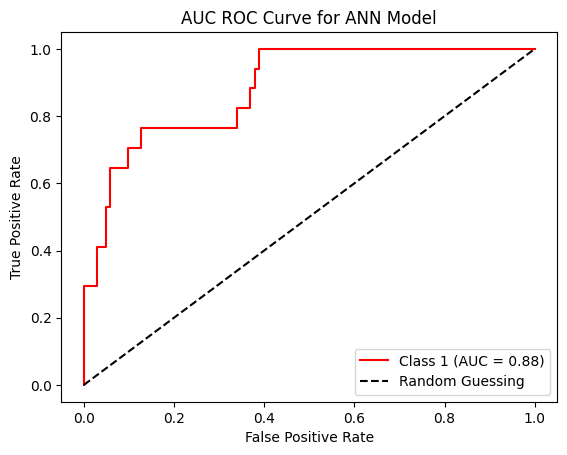

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# predict the probabilities of the test data using the trained model
y_pred_proba = ann.predict(x_test)

# convert y_test into a 2D array
y_test = np.array(y_test)
if y_test.ndim == 1:
    y_test = y_test[:, np.newaxis]

# calculate the ROC curve for each class
fpr = dict()
tpr = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])

# calculate the AUC ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

# plot the ROC curves for each class
plt.figure()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(1), colors):
  plt.plot(fpr[i], tpr[i], color=color, label='Class {} (AUC = {:.2f})'.format(i+1, auc_roc))
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC ROC Curve for ANN Model')
  plt.legend()
plt.show()



In [33]:
audio_test = "/content/drive/MyDrive/ALL/DC_n11.wav"
feature = get_features(audio_test)

In [34]:
feature=np.reshape(feature,(60))
feature=feature.reshape(1,-1)
scaler = StandardScaler()
feature = scaler.fit_transform(feature)

In [35]:
feature.shape

(1, 60)

In [36]:
# predict emotion label for single data point using trained model
predicted_label = np.argmax(ann.predict(x_test), axis=1)

# print predicted label
print("Predicted emotion label:", predicted_label)


4/4 [==============================] - 0s 3ms/step
Predicted emotion label: [3 6 2 4 4 1 6 6 4 2 4 0 5 5 5 1 1 4 6 4 1 4 2 0 4 6 0 3 3 6 0 3 3 4 3 3 5
 5 6 5 0 4 4 4 1 0 4 5 4 3 4 3 4 2 0 4 6 5 4 3 5 6 4 3 4 2 4 4 6 4 0 0 4 5
 3 0 4 1 4 6 1 6 2 3 4 5 3 4 0 3 4 6 4 4 2 4 2 2 1 4 2 2 3 2 6 4 2 4 5 5 0
 6 6 4 4 4 4 3 5 4]


In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_label)
print(cm)

accuracy = accuracy_score(np.argmax(y_test,axis=1), predicted_label)
precision = precision_score(np.argmax(y_test,axis=1), predicted_label, average='weighted')
recall = recall_score(np.argmax(y_test,axis=1), predicted_label, average='weighted')
f1 = f1_score(np.argmax(y_test,axis=1), predicted_label, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)



[[ 7  0  0  6  1  1  2]
 [ 1  4  3  1  2  1  2]
 [ 0  0  5  0  0  0  3]
 [ 3  0  1  7  0  0  2]
 [ 0  3  0  0 32  1  0]
 [ 0  1  0  0  5 11  0]
 [ 1  0  4  3  0  0  7]]
Accuracy:  0.6083333333333333
Precision:  0.6172181148100265
Recall:  0.6083333333333333
F1 Score:  0.6027374605827273


# LSTM

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.utils import to_categorical



# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Emotions['labels'])
y = to_categorical(y)  # One-hot encode the labels

X = Emotions.drop('labels', axis=1).values  # Features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for LSTM ( 60 features per sample)
input_shape = (X_train.shape[1], 1)  # (60, 1)
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1])
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1]))  # Output layer with the number of classes
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 100
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/100
6/6 [==============================] - 6s 468ms/step - loss: 1.8932 - accuracy: 0.2448 - val_loss: 1.7471 - val_accuracy: 0.3542
Epoch 2/100
6/6 [==============================] - 3s 477ms/step - loss: 1.7445 - accuracy: 0.2812 - val_loss: 1.6645 - val_accuracy: 0.3542
Epoch 3/100
6/6 [==============================] - 3s 436ms/step - loss: 1.7042 - accuracy: 0.2943 - val_loss: 1.6771 - val_accuracy: 0.3333
Epoch 4/100
6/6 [==============================] - 2s 288ms/step - loss: 1.6978 - accuracy: 0.2839 - val_loss: 1.6093 - val_accuracy: 0.3646
Epoch 5/100
6/6 [==============================] - 2s 286ms/step - loss: 1.6615 - accuracy: 0.3333 - val_loss: 1.5896 - val_accuracy: 0.3229
Epoch 6/100
6/6 [==============================] - 2s 282ms/step - loss: 1.6438 - accuracy: 0.3203 - val_loss: 1.5620 - val_accuracy: 0.3542
Epoch 7/100
6/6 [==============================] - 3s 515ms/step - loss: 1.6549 - accuracy: 0.2917 - val_loss: 1.5729 - val_accuracy: 0.3854
Epoch 8/100
6

# lstm+RNN

In [42]:
#MultiLayered
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, LSTM, SimpleRNN, Dense, Dropout, Activation
from keras.utils import to_categorical

# Load your extracted features (Emotions dataframe)
# Make sure you have Emotions dataframe with features and labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Emotions['labels'])
y = to_categorical(y)  # One-hot encode the labels

X = Emotions.drop('labels', axis=1).values  # Features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for RNN (60 features per sample)
input_shape = (X_train.shape[1], 1)  # (60, 1)
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1])
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])

# Define input layer
inputs = Input(shape=input_shape)

# RNN layer
rnn_layer = SimpleRNN(128, return_sequences=True)(inputs)
rnn_layer = Dropout(0.5)(rnn_layer)

# Additional LSTM layers
lstm_layer = LSTM(128, return_sequences=True)(rnn_layer)
lstm_layer = Dropout(0.5)(lstm_layer)
lstm_layer = LSTM(128)(lstm_layer)
lstm_layer = Dropout(0.5)(lstm_layer)

# Dense layers
dense_layer = Dense(128, activation='relu')(lstm_layer)
dense_layer = Dropout(0.5)(dense_layer)

# Output layer
outputs = Dense(y.shape[1], activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 100
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/100
6/6 [==============================] - 8s 558ms/step - loss: 1.9609 - accuracy: 0.1276 - val_loss: 1.9046 - val_accuracy: 0.2708
Epoch 2/100
6/6 [==============================] - 2s 424ms/step - loss: 1.9133 - accuracy: 0.2031 - val_loss: 1.8414 - val_accuracy: 0.3125
Epoch 3/100
6/6 [==============================] - 4s 605ms/step - loss: 1.8526 - accuracy: 0.2266 - val_loss: 1.7343 - val_accuracy: 0.3542
Epoch 4/100
6/6 [==============================] - 2s 336ms/step - loss: 1.8213 - accuracy: 0.2240 - val_loss: 1.6595 - val_accuracy: 0.3750
Epoch 5/100
6/6 [==============================] - 2s 329ms/step - loss: 1.7482 - accuracy: 0.3125 - val_loss: 1.6511 - val_accuracy: 0.3542
Epoch 6/100
6/6 [==============================] - 2s 352ms/step - loss: 1.7070 - accuracy: 0.2891 - val_loss: 1.6374 - val_accuracy: 0.3333
Epoch 7/100
6/6 [==============================] - 2s 355ms/step - loss: 1.7226 - accuracy: 0.2682 - val_loss: 1.6593 - val_accuracy: 0.3750
Epoch 8/100
6

3/3 [==============================] - 1s 81ms/step
Accuracy: 0.5625
Precision: 0.5784316378066378
Recall: 0.5625
F1 Score: 0.5657685626827115


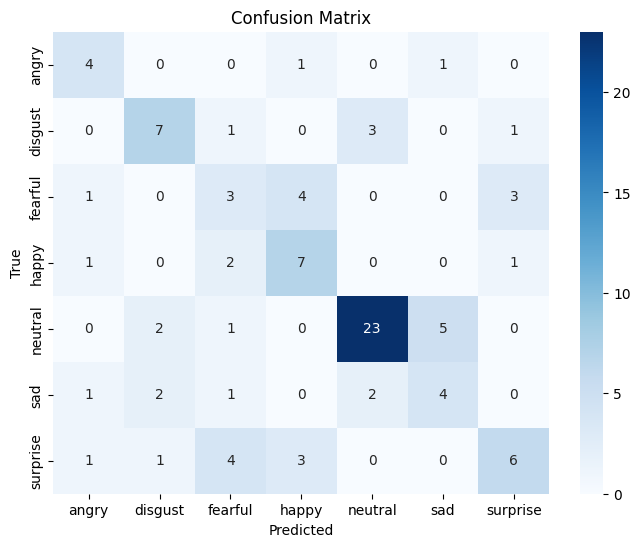

In [43]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and ground truth back to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# BiDirectional LSTM

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from keras.utils import to_categorical

# Load your extracted features (Emotions dataframe)
# Make sure you have Emotions dataframe with features and labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Emotions['labels'])
y = to_categorical(y)  # One-hot encode the labels

X = Emotions.drop('labels', axis=1).values  # Features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for Bi-LSTM (assuming you have 60 features per sample)
input_shape = (X_train.shape[1], 1)  # (60, 1)
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1])
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1]))  # Output layer with the number of classes
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 100
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),shuffle=True)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/100
6/6 [==============================] - 14s 962ms/step - loss: 1.8927 - accuracy: 0.2214 - val_loss: 1.6753 - val_accuracy: 0.3438
Epoch 2/100
6/6 [==============================] - 5s 915ms/step - loss: 1.6931 - accuracy: 0.2969 - val_loss: 1.6525 - val_accuracy: 0.3646
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 1.6903 - accuracy: 0.3021 - val_loss: 1.6273 - val_accuracy: 0.3750
Epoch 4/100
6/6 [==============================] - 6s 1s/step - loss: 1.6488 - accuracy: 0.3151 - val_loss: 1.5688 - val_accuracy: 0.4479
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 1.6237 - accuracy: 0.3151 - val_loss: 1.5822 - val_accuracy: 0.3542
Epoch 6/100
6/6 [==============================] - 3s 572ms/step - loss: 1.5967 - accuracy: 0.3229 - val_loss: 1.5455 - val_accuracy: 0.4271
Epoch 7/100
6/6 [==============================] - 5s 989ms/step - loss: 1.5384 - accuracy: 0.3255 - val_loss: 1.5110 - val_accuracy: 0.3958
Epoch 8/100
6/6 [====

3/3 [==============================] - 2s 121ms/step
Accuracy: 0.4791666666666667
Precision: 0.5040088383838384
Recall: 0.4791666666666667
F1 Score: 0.4715405713567478


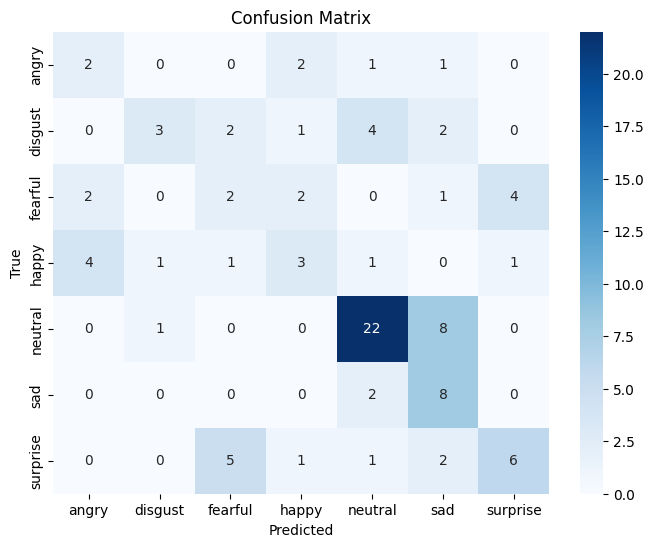

In [45]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and ground truth back to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# RNN

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Activation
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your extracted features (Emotions dataframe)
# Make sure you have Emotions dataframe with features and labels

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Emotions['labels'])
y = to_categorical(y)  # One-hot encode the labels

X = Emotions.drop('labels', axis=1).values  # Features

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the features for RNN (assuming you have 60 features per sample)
input_shape = (X_train.shape[1], 1)  # (60, 1)
X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1])
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(256, input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer with the number of classes


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 100
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test),shuffle=True)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/100
6/6 [==============================] - 3s 247ms/step - loss: 2.2137 - accuracy: 0.2214 - val_loss: 1.7376 - val_accuracy: 0.3438
Epoch 2/100
6/6 [==============================] - 1s 147ms/step - loss: 2.0252 - accuracy: 0.2526 - val_loss: 1.6530 - val_accuracy: 0.3958
Epoch 3/100
6/6 [==============================] - 1s 126ms/step - loss: 1.9311 - accuracy: 0.2812 - val_loss: 1.6382 - val_accuracy: 0.3646
Epoch 4/100
6/6 [==============================] - 1s 104ms/step - loss: 1.8247 - accuracy: 0.2891 - val_loss: 1.6275 - val_accuracy: 0.3646
Epoch 5/100
6/6 [==============================] - 0s 84ms/step - loss: 1.7159 - accuracy: 0.3516 - val_loss: 1.6080 - val_accuracy: 0.4062
Epoch 6/100
6/6 [==============================] - 1s 90ms/step - loss: 1.6953 - accuracy: 0.3359 - val_loss: 1.6083 - val_accuracy: 0.3854
Epoch 7/100
6/6 [==============================] - 1s 87ms/step - loss: 1.7109 - accuracy: 0.3359 - val_loss: 1.6082 - val_accuracy: 0.3646
Epoch 8/100
6/6 

3/3 [==============================] - 0s 18ms/step
Accuracy: 0.5416666666666666
Precision: 0.5541502768065268
Recall: 0.5416666666666666
F1 Score: 0.5407763473698071


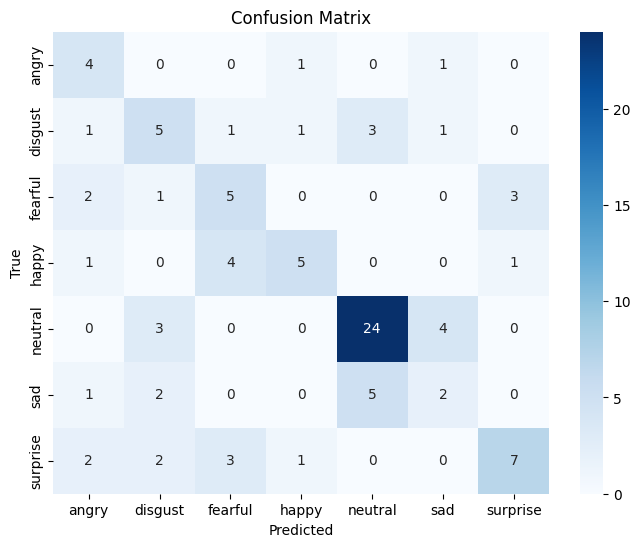

In [49]:
# Predict on the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and ground truth back to labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# deployment

In [50]:
import os
import sys
import pickle

projectabspathname = os.path.abspath('projectname.pickle')
print(projectabspathname)
projectname = 'projectname.ipynb'
projectpickle = open(str(projectabspathname),'wb')
pickle.dump(projectname, projectpickle)
projectpickle.close()

/content/projectname.pickle
